In [2]:
import numpy as np 
import re 
import requests as req 
import itertools as it
import matplotlib.pyplot as plt 
import pandas as pd 
from sodapy import Socrata
import geopy as gp
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import collections as col
from imblearn.over_sampling import SMOTENC, SMOTEN, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [2]:
#FOUND API. no need for requests
# requ_url = 'https://www.dot.ny.gov/portal/pls/portal/MEXIS_APP.DYN_PROJECT_DETAILS.show'
# req_post = {'p_arg_names': 'p_pin', 'p_arg_values':801079}
# # resp = req.get(requ_url)
# def data_retrieval(url: str, key: list[str]) -> pd.DataFrame:
#     response = req.get(url)
#     if response.ok == True and response.status_code == 200:
#         print('Success')
#     else:
#         print('Failed')
#     data = response.json()
#     return data
# response = req.get(requ_url, params=req_post)
# print(response.text)

In [3]:
client = Socrata("data.ny.gov",app_token='SUV6CnpKWErb1fdYcxWDEXpHl', username='dwightdinkins@gmail.com',password='AVelaryon@2134')
results = client.get("rz8t-4kmq", limit=5000)
results_df = pd.DataFrame.from_records(results)
results_df.columns

Index(['major_pin', 'contract_number', 'region', 'project_title',
       'project_status', 'status', 'bid_opening_date', 'federal_funding',
       'state_funding', 'local_funding', 'type_of_work',
       'public_friendly_description', 'contract_award_date',
       'contract_award_amount', 'approved_cost_changes',
       'current_award_amount', 'estimated_or_actual_completed_date',
       'schedule_performance', 'cost_performance',
       'in_future_development_start_date', 'construction_start_date',
       'construction_end_date', 'construction_amount'],
      dtype='object')

# Data Pre-processing

In [4]:
group_status = results_df.groupby(by='status', as_index=False)
indx = (results_df.status.str.contains('Completed Project', regex=False).to_numpy() == 1).nonzero()

In [5]:
pd.set_option('display.max_columns', 23)
completed = results_df.iloc[indx[0],:].copy()
# Converted COntract Award Date & Estimated Completion Date to Datetime Objects
completed.contract_award_date = pd.to_datetime(completed.contract_award_date)
completed.estimated_or_actual_completed_date = pd.to_datetime(completed.estimated_or_actual_completed_date)

In [6]:
completed_dropped_contruct = completed.drop(columns=['construction_start_date', 'construction_end_date', 'construction_amount']).copy()

In [6]:
completed_dropped_contruct

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Bicycle Facility (Highway): New,Project proposes to construct the 3rd phase of...,2019-07-12,16193713,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement: Mill and Fill,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.4,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,"Pavement: Concrete Pavement Repair, Heavy",This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail/Median Barrier: Rehab/Improve,This project proposes to replace existing the ...,2019-11-06,4464797.2,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,XM1850,D264063,11 NEW YORK CITY,"ADA REQUIREMENTS IN BRONX CO., NYC","Build curb ramps, crosswalks and sidewalks at ...",Completed Project,11/21/2019,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project will build (either throught repla...,2020-01-08,874049.9,-282679.6,591370.3,2020-10-08,GREEN,GREEN,Fall 2018
1903,XM1860,D263918,11 NEW YORK CITY,CORRECTIVE & PREVENTIVE MAINTENANCE OF RETAINI...,CORRECTIVE AND REVENTIVE MAINTENANCE OF MASON...,Completed Project,03/28/2019,Yes,Yes,No,Retaining Wall: New/Improve/Rehab,"This project will repair and restore brick, st...",2019-06-25,14199865.45,-575172.71,13624692.74,2020-11-17,GREEN,GREEN,Summer 2015
1904,XM1921,D263839,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Completed Project,11/29/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform emergency steel repa...,2019-01-17,10555555,-690065.36,9865489.64,2021-01-19,GREEN,GREEN,Spring 2018
1905,XM1922,D263809,11 NEW YORK CITY,"CORRECTIVE MAINTENANCE REPAIR CONTRACT (NSCO),...","Address NSCO, flags & other conditions on brid...",Completed Project,12/13/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform maintenance repairs ...,2019-04-16,26680095,1113136.22,27793231.22,2020-10-19,RED,GREEN,Spring 2018


In [7]:

def modify_addy(regex: list[str], data: pd.DataFrame, dat_col: pd.Series):
    geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
    geolocator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    hwy_data = dat_col.str.replace(regex[0],r'\1-\2', regex=True).str.extract(regex[1]).dropna()
    loc_data = col.defaultdict(dict)
    for indx, hwy in hwy_data.to_dict()[0].items():
        try:
            location = geolocator(hwy + ', NY', geometry='geojson')
            if location != None:
                loc_data['latitude'][indx] = location.latitude
                loc_data['longitude'][indx] = location.longitude
                # print(loc_data['longitude'][indx])
            else:
                loc_data['latitude'][indx] = np.nan
                loc_data['longitude'][indx] = np.nan
        except OSError:
            pass        

    return loc_data
    
    

In [ ]:
# regex = [r'([NYIRtT\.]+)\s?(\d+)',r'([NYIRtT\.]+-\d+)']
# location_data = modify_addy(regex, completed_dropped_contruct, completed_dropped_contruct.project_status)

In [ ]:
# location_data1 = modify_addy(regex, completed_dropped_contruct, completed_dropped_contruct.project_title)

In [10]:
location_data = pd.read_excel(r"C:\Users\dwigh\Downloads\location_data1.xlsx")
location_data1 = pd.read_excel(r"C:\Users\dwigh\Downloads\location_data.xlsx")

In [9]:
location_data

,Unnamed: 0,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
0,0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Bicycle Facility (Highway): New,Project proposes to construct the 3rd phase of...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
1,17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement: Mill and Fill,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
2,20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
3,21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,"Pavement: Concrete Pavement Repair, Heavy",This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
4,29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail/Median Barrier: Rehab/Improve,This project proposes to replace existing the ...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,1900,XM1850,D264063,11 NEW YORK CITY,"ADA REQUIREMENTS IN BRONX CO., NYC","Build curb ramps, crosswalks and sidewalks at ...",Completed Project,11/21/2019,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project will build (either throught repla...,2020-01-08,874049.90,-282679.60,591370.30,2020-10-08,GREEN,GREEN,Fall 2018,40.846651,-73.878594
287,1903,XM1860,D263918,11 NEW YORK CITY,CORRECTIVE & PREVENTIVE MAINTENANCE OF RETAINI...,CORRECTIVE AND REVENTIVE MAINTENANCE OF MASON...,Completed Project,03/28/2019,Yes,Yes,No,Retaining Wall: New/Improve/Rehab,"This project will repair and restore brick, st...",2019-06-25,14199865.45,-575172.71,13624692.74,2020-11-17,GREEN,GREEN,Summer 2015,40.712728,-74.006015
288,1904,XM1921,D263839,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Completed Project,11/29/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform emergency steel repa...,2019-01-17,10555555.00,-690065.36,9865489.64,2021-01-19,GREEN,GREEN,Spring 2018,40.712728,-74.006015
289,1905,XM1922,D263809,11 NEW YORK CITY,"CORRECTIVE MAINTENANCE REPAIR CONTRACT (NSCO),...","Address NSCO, flags & other conditions on brid...",Completed Project,12/13/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform maintenance repairs ...,2019-04-16,26680095.00,1113136.22,27793231.22,2020-10-19,RED,GREEN,Spring 2018,40.712728,-74.006015


In [11]:
location_data.set_index('Unnamed: 0', inplace=True)
location_data.index.name = ''

location_data1.set_index('Unnamed: 0', inplace=True)
location_data1.index.name = ''

In [ ]:
location_data

In [ ]:
location_data1[location_data1.longitude.isna()].shape

In [ ]:
pd.set_option('display.max_rows', 300)
regex = r'(\d+\s\w+\s[RAdVEveoOaD]+)'
regex1 = r'(\s[\w\s]+and\s[\w\s]+)'
regex2 = r'(?<=between\s)([\w\s]+)and([\w\s]+)'
regex3 = r'(?<=FROM\s)([\w\d\s]+)'
regex4 = r'([NYIRtT\.]+)\s?(\d+)'
regex5 = r'([NYIRtT\.]+-\d+)'
# completed_dropped_contruct.project_status.str.replace(regex4, r'\1-\2', regex=True).str.extract(regex5).dropna()
for i, descrip in location_data[location_data.longitude.isna()].project_status.to_dict().items():
    print(f'{i}: {descrip},')


In [ ]:
location_data[location_data.longitude.isna()]

In [12]:
location_data.loc[1540, ['latitude', 'longitude']] = [42.252865, -73.790962]

In [12]:
rem ={
    0: "Captree State Park",
    32: "Hempstead",
    33: "Commack Rd, Huntington",
    41: "Nassau",
    42: "SUFFOLK",
    43: "NY-25A",
    44: "Nassau",
    46: "SUFFOLK",
    48: "NY-347",
    49: "NY-231",
    51: "Riverhead",
    59: "Nassau",
    62: "Montauk Hwy",
    63: "Old Sunrise Highway",
    64: "William Floyd Pkwy",
    68: "NY-27",
    93: "NY-24",
    254: "New York State",
    279: "ROUTE 29",
    327: "NEW YORK CITY",
    329: "Mohawk Hudson Bike Trail",
    403: "EMPIRE STATE TRAIL",
    442: "NY-418",
    485: "ONEIDA",
    487: "EAST HERKIMER",
    488: "TRENTON & REMSEN",
    490: "HERKIMER",
    491: "NEW HARTFORD",
    497: "New York State",
    503: "New York State",
    580: "Geddes",
    581: "Bronx",
    621: "New York City",
    638: "Manlius",
    644: "ONONDAGA",
    648: "SENECA COUNTY",
    649: "CORTLAND COUNTY",
    652: "TOMPKINS COUNTY",
    668: "TOMPKINS COUNTY",
    671: "I-690",
    672: "CAYUGA",
    676: "OSWEGO",
    759: "MONROE COUNTY",
    769: "Orleans County",
    774: "Empire State Trail",
    775: "MACEDON",
    803: "Edgemere Dr.",
    862: "Livingston County",
    900: "New York State",
    913: "ROUTE 179",
    931: "Amherst",
    934: "Erie County",
    936: "Cattaraugus County",
    939: "Niagara County",
    940: "ERIE COUNTY",
    943: "Niagara County",
    944: "Lewiston",
    949: "Chautauqua",
    951: "Erie County",
    963: "US-62",
    1040: "CATTARAUGUS COUNTY",
    1041: "ERIE COUNTY",
    1042: "NY-426",
    1103: "Empire State Trail",
    1112: "US-20",
    1114: "US-62",
    1120: "US-20",
    1126: "US-20A",
    1128: "NIAGARA FALLS BLVD",
    1130: "New York State",
    1173: "Chemung",
    1177: "SCHUYLER",
    1178: "STEUBEN",
    1179: "I-86",
    1181: "STEUBEN & YATES",
    1229: "YATES",
    1234: "Schuyler & Steuben",
    1289: "New York State",
    1291: "New York State",
    1292: "New York State",
    1293: "New York State",
    1294: "Central New York",
    1296: "Central New York",
    1297: "New York State",
    1332: "New York State",
    1344: "ROUTE 116",
    1346: "ROUTE 100",
    1351: "ROUTE 203",
    1373: "ROUTE 22",
    1383: "ANNSVILLE CIRCLE",
    1387: "ROUTE 202",
    1388: "OAKLEY BOULEVARD",
    1399: "New York State",
    1402: "ROCKLAND & WESTCHESTER COUNTY",
    1403: "New York State",
    1405: "ROCKLAND COUNTY",
    1406: "Putnam & Ulster",
    1409: "ROUTE 213",
    1413: "ORANGE & WESTCHESTER",
    1415: "Dutchess County",
    1416: "PUTNAM County",
    1440: "New York State",
    1450: "Westchester",
    1455: "New York State",
    1462: "New York State",
    1469: "New York State",
    1476: "New York State",
    1484: "Orange & Putnam",
    1487: "Rockland",
    1489: "Ulster",
    1520: "SAW MILL RIVER PARKWAY",
    1522: "PUTNAM & WESTCHESTER",
    1528: "GREENBURGH",
    1529: "HAVERSTRAW",
    1536: "Route 44",
    1538: "ROUTE 17K",
    1539: "HUNGRY HOLLOW ROAD",
    1540: "NEW PALTZ & LLYOD",
    1635: "ROUTE 59",
    1637: "TACONIC PARKWAY",
    1639: "EMPIRE STATE TRAIL, KINGSTON",
    1640: "ALBANY HUDSON ELECTRIC TRAIL",
    1654: "Bethel",
    1673: "Owego",
    1717: "Chenango",
    1719: "US-11",
    1761: "Wyoming",
    1787: "Route 97",
    1866: "I-278",
    1882: "Van Wyck Expressway",
    1887: "New York City",
    1894: "New York State",
    1895: "New York City",
    1896: "New York City",
    1897: "New York City",
    1898: "New York city",
    1900: "Bronx",
    1903: "New York City",
    1904: "NYC",
    1905: "NYC",
    1908: "West 57th St."
}


In [ ]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
location = geolocator.geocode('West 57th St., NY', geometry='geojson', exactly_one=True)
location.latitude, location.longitude

In [ ]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
geolocator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
loc_data = col.defaultdict(dict)
for indx, hwy in rem.items():
    try:
        location = geolocator(hwy + ', NY', geometry='geojson')
        if location != None:
            loc_data['latitude'][indx] = location.latitude
            loc_data['longitude'][indx] = location.longitude
            # print(loc_data['longitude'][indx])
        else:
            loc_data['latitude'][indx] = np.nan
            loc_data['longitude'][indx] = np.nan
    except OSError:
        pass

In [ ]:
# location_data[['latitude', 'longitude']] = location_data[['latitude', 'longitude']].combine_first(pd.DataFrame(loc_data))

In [ ]:
# (location_data[['latitude', 'longitude']].isna() == True).to_numpy().nonzero()

In [13]:
tow = location_data.type_of_work.str.replace('/',' ').str.replace(':', '').str.replace('(','').str.replace(')','').str.replace(',','')
tow


0                    Bicycle Facility Highway New
17                         Pavement Mill and Fill
20      Pedestrian Facility Highway Improve Rehab
21        Pavement Concrete Pavement Repair Heavy
29         Guiderail Median Barrier Rehab Improve
                          ...                    
1900    Pedestrian Facility Highway Improve Rehab
1903             Retaining Wall New Improve Rehab
1904             Emergency Response Bridge Repair
1905             Emergency Response Bridge Repair
1908      Pavement Concrete Pavement Repair Heavy
Name: type_of_work, Length: 291, dtype: object

In [14]:
words = tow.str.split().to_numpy()
unique_set = list()
for word in words:
  print(word)
  unique_set.extend(word)
num_of_appearance = dict()
for item in set(unique_set):
  num_of_appearance[item] = unique_set.count(item)

['Bicycle', 'Facility', 'Highway', 'New']
['Pavement', 'Mill', 'and', 'Fill']
['Pedestrian', 'Facility', 'Highway', 'Improve', 'Rehab']
['Pavement', 'Concrete', 'Pavement', 'Repair', 'Heavy']
['Guiderail', 'Median', 'Barrier', 'Rehab', 'Improve']
['Pavement', 'Mill', 'and', 'Fill']
['Guiderail', 'Median', 'Barrier', 'Rehab', 'Improve']
['Bridge', 'Replacement', 'Functional']
['Traffic', 'Signals', 'Devices', 'Coordination']
['Bridge', 'Maintenance', 'Cyclical', 'Washing', 'Sealing', 'Cleaning', 'etc.']
['Pavement', 'Mill', 'and', 'Fill']
['Other']
['Emergency', 'Response', 'Highway']
['Pavement', 'Mill', 'and', 'Fill']
['Pavement', 'Mill', 'and', 'Fill']
['Bridge', 'Deck', 'Replacement']
['Pavement', 'Marking']
['Pavement', 'Crack', 'or', 'Joint', 'Sealing']
['Pavement', 'Concrete', 'Pavement', 'Repair', 'Heavy']
['Pavement', 'Mill', 'and', 'Fill']
['Pavement', 'Mill', 'and', 'Fill']
['Pedestrian', 'Facility', 'Highway', 'New']
['Bridge', 'Vertical', 'Down', 'Rehab']
['Pavement', 'Sing

In [ ]:
num_of_appearance

In [15]:
pattern = re.compile(r'(Bridge|Pavement|Highway|Traffic|Guiderail|Culvert|Drainage|Vegetation)')
categories = tow.str.extract(pattern)
categories

,0
,
0,Highway
17,Pavement
20,Highway
21,Pavement
29,Guiderail
...,...
1900,Highway
1903,NaN
1904,Bridge


In [16]:
location_data.type_of_work[categories[0].isna()] = 'Other'
location_data.type_of_work[categories[0].notna()] = categories[0]

C:\Users\dwigh\AppData\Local\Temp\ipykernel_15640\634246089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data.type_of_work[categories[0].isna()] = 'Other'
C:\Users\dwigh\AppData\Local\Temp\ipykernel_15640\634246089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data.type_of_work[categories[0].notna()] = categories[0]


In [17]:
# pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 23)
location_data.head(5)

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
,,,,,,,,,,,,,,,,,,,,,,
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Highway,Project proposes to construct the 3rd phase of...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Highway,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,Pavement,This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail,This project proposes to replace existing the ...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219


In [20]:
x_columns = ['major_pin', 'contract_number', 'region', 'status', 'bid_opening_date', 'federal_funding',
       'state_funding', 'local_funding', 'type_of_work',
        'contract_award_date',
       'contract_award_amount', 'approved_cost_changes',
       'current_award_amount',
       'schedule_performance', 'cost_performance',
        'latitude', 'longitude']
y_column = 'current_award_amount'

In [ ]:
# smote = SMOTEN(sampling_strategy='minority', random_state=0)
# X, Y = smote.fit_resample(location_data.loc[:,x_columns], location_data.loc[:,y_column])
# location_data.type_of_work.value_counts()
(location_data[location_data.contract_number.isna()]).index

In [18]:
dropped_contract_numbers = location_data.drop(index = (location_data[location_data.contract_number.isna()]).index).copy()

In [19]:
dropped_contract_numbers.contract_award_date = dropped_contract_numbers.contract_award_date.sort_values(ascending=True)
def time_features(data: pd.DataFrame):
    data['month'] = data.contract_award_date.dt.month
    data['day'] = data.contract_award_date.dt.day
    data['year'] = data.contract_award_date.dt.year
    return data

dropped_contract_numbers = time_features(dropped_contract_numbers)

In [20]:
dropped_contract_numbers = dropped_contract_numbers.drop(columns=['public_friendly_description','region', 'project_title', 'project_status', 'major_pin', 'contract_number', 'bid_opening_date',
                                                                 'current_award_amount', 'schedule_performance', 'cost_performance',
                                                                'in_future_development_start_date'])

In [21]:
dropped_contract_numbers.sort_values(by='contract_award_date', ascending=True, inplace=True)

In [20]:
new_x_columns = dropped_contract_numbers.columns

In [22]:
dropped_contract_numbers.federal_funding = dropped_contract_numbers.federal_funding.astype('category')
dropped_contract_numbers.state_funding = dropped_contract_numbers.state_funding.astype('category')
dropped_contract_numbers.local_funding = dropped_contract_numbers.local_funding.astype('category')

dropped_contract_numbers.month = dropped_contract_numbers.month.astype('category')
dropped_contract_numbers.day = dropped_contract_numbers.day.astype('category')
dropped_contract_numbers.year = dropped_contract_numbers.year.astype('category')

In [23]:
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Vegetation', 'Other')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Culvert','Drainage')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Guiderail','Traffic')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Pavement','Highway')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Bridge','Highway')


In [21]:
dropped_contract_numbers.head()

,status,federal_funding,state_funding,local_funding,type_of_work,contract_award_date,contract_award_amount,approved_cost_changes,estimated_or_actual_completed_date,latitude,longitude,month,day,year
,,,,,,,,,,,,,,
1865,Completed Project,Yes,Yes,No,Highway,2016-04-18,52841785.00,30400547.78,2019-07-01,49.870295,19.046648,4,18,2016
1894,Completed Project,No,Yes,No,Highway,2017-05-04,19119060.00,3269841.52,2020-10-07,43.001888,-78.785214,5,4,2017
301,Completed Project,No,Yes,No,Traffic,2017-05-15,846355.00,-188516.15,2020-10-28,43.206267,-77.691073,5,15,2017
254,Completed Project,Yes,No,No,Highway,2017-07-20,2822547.16,-639003.78,2020-09-23,43.001888,-78.785214,7,20,2017
1289,Completed Project,No,Yes,No,Drainage,2017-12-12,1008900.00,58687.04,2020-10-05,43.001888,-78.785214,12,12,2017


<Figure size 1920x1440 with 0 Axes>

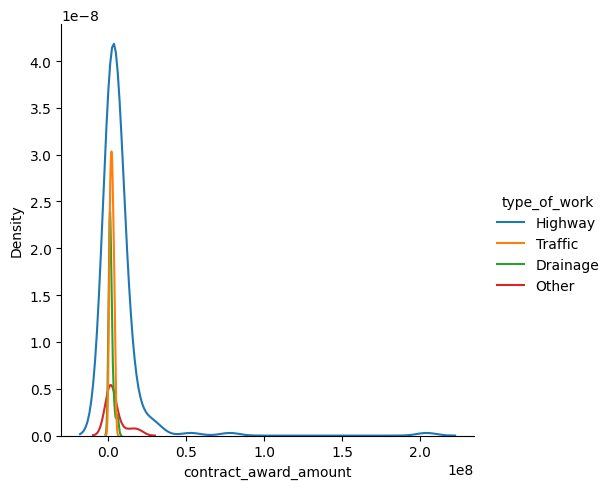

In [24]:
import seaborn as sns
plt.figure(dpi=300)
sns.displot(dropped_contract_numbers, x='contract_award_amount', hue='type_of_work', kind='kde')

In [25]:
cleaned_data = dropped_contract_numbers.drop(columns=['status','contract_award_amount', 'approved_cost_changes','estimated_or_actual_completed_date'])

In [26]:
current_award_amount = location_data.loc[cleaned_data.index, 'current_award_amount']

In [27]:
cleaned_data

,federal_funding,state_funding,local_funding,type_of_work,contract_award_date,latitude,longitude,month,day,year
,,,,,,,,,,
1865,Yes,Yes,No,Highway,2016-04-18,49.870295,19.046648,4,18,2016
1894,No,Yes,No,Highway,2017-05-04,43.001888,-78.785214,5,4,2017
301,No,Yes,No,Traffic,2017-05-15,43.206267,-77.691073,5,15,2017
254,Yes,No,No,Highway,2017-07-20,43.001888,-78.785214,7,20,2017
1289,No,Yes,No,Drainage,2017-12-12,43.001888,-78.785214,12,12,2017
...,...,...,...,...,...,...,...,...,...,...
1710,Yes,Yes,No,Highway,2021-03-09,43.066991,-76.165387,3,9,2021
884,Yes,Yes,No,Highway,2021-03-12,42.106859,-75.852201,3,12,2021
1344,No,Yes,No,Highway,2021-03-12,40.945188,-72.886521,3,12,2021


<Axes: ylabel='Density'>

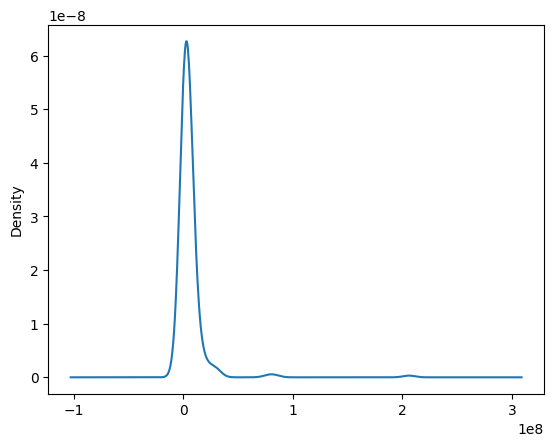

In [29]:
current_award_amount.plot(kind='kde')

In [28]:
z_caa_scores = current_award_amount.apply(lambda x: (x- current_award_amount.mean())/(current_award_amount.std())).copy()

In [29]:
z_caa_scores.drop(index=z_caa_scores[z_caa_scores>3].index, inplace=True)

In [30]:
norm_caa = current_award_amount.apply(lambda x: x/100_000).copy()
norm_caa = norm_caa[z_caa_scores.index]

In [31]:
cleaned_data = cleaned_data.loc[z_caa_scores.index]

In [32]:
norm_caa


1894    223.889015
301       6.578388
254      21.835434
1289     10.675870
42        8.464000
           ...    
1710     39.741378
884      85.360000
1344      2.940645
1294      8.478478
803       5.722370
Name: current_award_amount, Length: 229, dtype: float64

In [122]:
categories = [
	cleaned_data['federal_funding'].unique().tolist(),
	cleaned_data['state_funding'].unique().tolist(),
	cleaned_data['local_funding'].unique().tolist(),
	cleaned_data['type_of_work'].unique().tolist(),
]
ord_columns = [ 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']
ordinal = OrdinalEncoder(categories=categories)
ordinal.fit(cleaned_data[ord_columns])

OrdinalEncoder(categories=[['No', 'Yes'], ['Yes', 'No'], ['No', 'Yes'],
                           ['Highway', 'Traffic', 'Drainage', 'Other']])

In [33]:
ordinal.transform(cleaned_data[ord_columns]).shape

(229, 4)

In [123]:
from sklearn.preprocessing import KBinsDiscretizer
nun = len(cleaned_data.type_of_work.unique().tolist())
discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
Y_binned = discret.fit_transform(norm_caa.to_numpy().reshape((-1,1))).ravel()

smote = SMOTENC(categorical_features=[0],random_state=0)
X, Y = smote.fit_resample(np.hstack((ordinal.transform(cleaned_data[ord_columns]),cleaned_data[['month','day','year','latitude','longitude']])), Y_binned)

In [124]:
current_award_amount


1865    83242332.78
1894    22388901.52
301       657838.85
254      2183543.38
1289     1067587.04
           ...     
1710     3974137.82
884      8536000.00
1344      294064.49
1294      847847.84
803       572237.00
Name: current_award_amount, Length: 232, dtype: float64

In [125]:
Y = pd.DataFrame(discret.inverse_transform(Y.reshape((-1,1))),columns=['current_award_amount'])

In [126]:
X = pd.DataFrame(X, columns = ord_columns + ['month','day','year','latitude','longitude'])

In [127]:
Y

,current_award_amount
0,177.129008
1,7.145599
2,19.669586
3,7.145599
4,7.145599
...,...
227,7.145599
228,7.145599
229,7.145599
230,19.669586


In [115]:
# Only for Standardization
# norm_caa = norm_caa.drop(index = norm_caa[norm_caa > 4].index)
# Y.current_award_amount = Y.current_award_amount.apply(lambda x: (x-Y.min())/(Y.max()-Y.min()))

In [128]:
Y

,current_award_amount
0,177.129008
1,7.145599
2,19.669586
3,7.145599
4,7.145599
...,...
227,7.145599
228,7.145599
229,7.145599
230,19.669586


In [129]:
X

,federal_funding,state_funding,local_funding,type_of_work,month,day,year,latitude,longitude
0,0.0,0.0,0.0,0.0,5.000000,4.000000,2017.000000,43.001888,-78.785214
1,0.0,0.0,0.0,1.0,5.000000,15.000000,2017.000000,43.206267,-77.691073
2,1.0,1.0,0.0,0.0,7.000000,20.000000,2017.000000,43.001888,-78.785214
3,0.0,0.0,0.0,2.0,12.000000,12.000000,2017.000000,43.001888,-78.785214
4,0.0,0.0,0.0,0.0,1.000000,30.000000,2018.000000,40.883232,-72.857803
...,...,...,...,...,...,...,...,...,...
227,1.0,0.0,0.0,0.0,3.000000,15.000000,2021.000000,40.752694,-73.977253
228,0.0,0.0,0.0,0.0,5.000000,6.000000,2021.000000,40.597798,-73.775490
229,1.0,0.0,0.0,0.0,3.407155,14.592845,2020.592845,41.835159,-74.852935
230,1.0,0.0,0.0,0.0,3.000000,4.185689,2019.407155,42.556725,-74.557718


In [130]:
# columns_to_transform = ['region', 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']
# transformed_data = pd.DataFrame(np.hstack((ordinal.transform(cleaned_data[columns_to_transform]), cleaned_data[['latitude', 'longitude']].to_numpy())), columns=columns_to_transform + ['latitude', 'longitude'], index=cleaned_data.index)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,shuffle=False, random_state=0)

In [154]:
# n_estimators=126, min_samples_split=10, min_samples_leaf=5
# n_estimators=10, min_samples_split=10, min_samples_leaf=6, max_samples=47, 
RF = RandomForestRegressor(n_estimators=300, random_state=0)
RF.fit(X_train, y_train)
print(f'Training Score: {np.square(y_train.to_numpy().ravel() - RF.predict(X_train)).mean()}')
print(f'Testing Score: {np.square(y_test.to_numpy().ravel() - RF.predict(X_test)).mean()}')   

Training Score: 641.944650503669
Testing Score: 3442.5382396984714


c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [107]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
param_space = dict()
param_space['n_estimators'] = Integer(10,350)
param_space['max_samples'] = Integer(10,100)
param_space['min_samples_split'] = Integer(5,20)
param_space['min_samples_leaf'] = Integer(2,10)
bae = BayesSearchCV(RF, param_space, n_iter=200, n_jobs=16, n_points=4, cv=4, random_state=0)
bae.fit(X_train,y_train)
print(f'Best Params: {bae.best_params_} and Score: {bae.best_score_}')

c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(76), np.int64(10), np.int64(20), np.int64(10)] before, using random point [np.int64(36), np.int64(4), np.int64(18), np.int64(218)]
  warnings.warn(
c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(40), np.int64(10), np.int64(5), np.int64(350)] before, using random point [np.int64(24), np.int64(9), np.int64(12), np.int64(43)]
  warnings.warn(
c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(d

Best Params: OrderedDict({'max_samples': 40, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 24}) and Score: -0.013469665755855564


c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


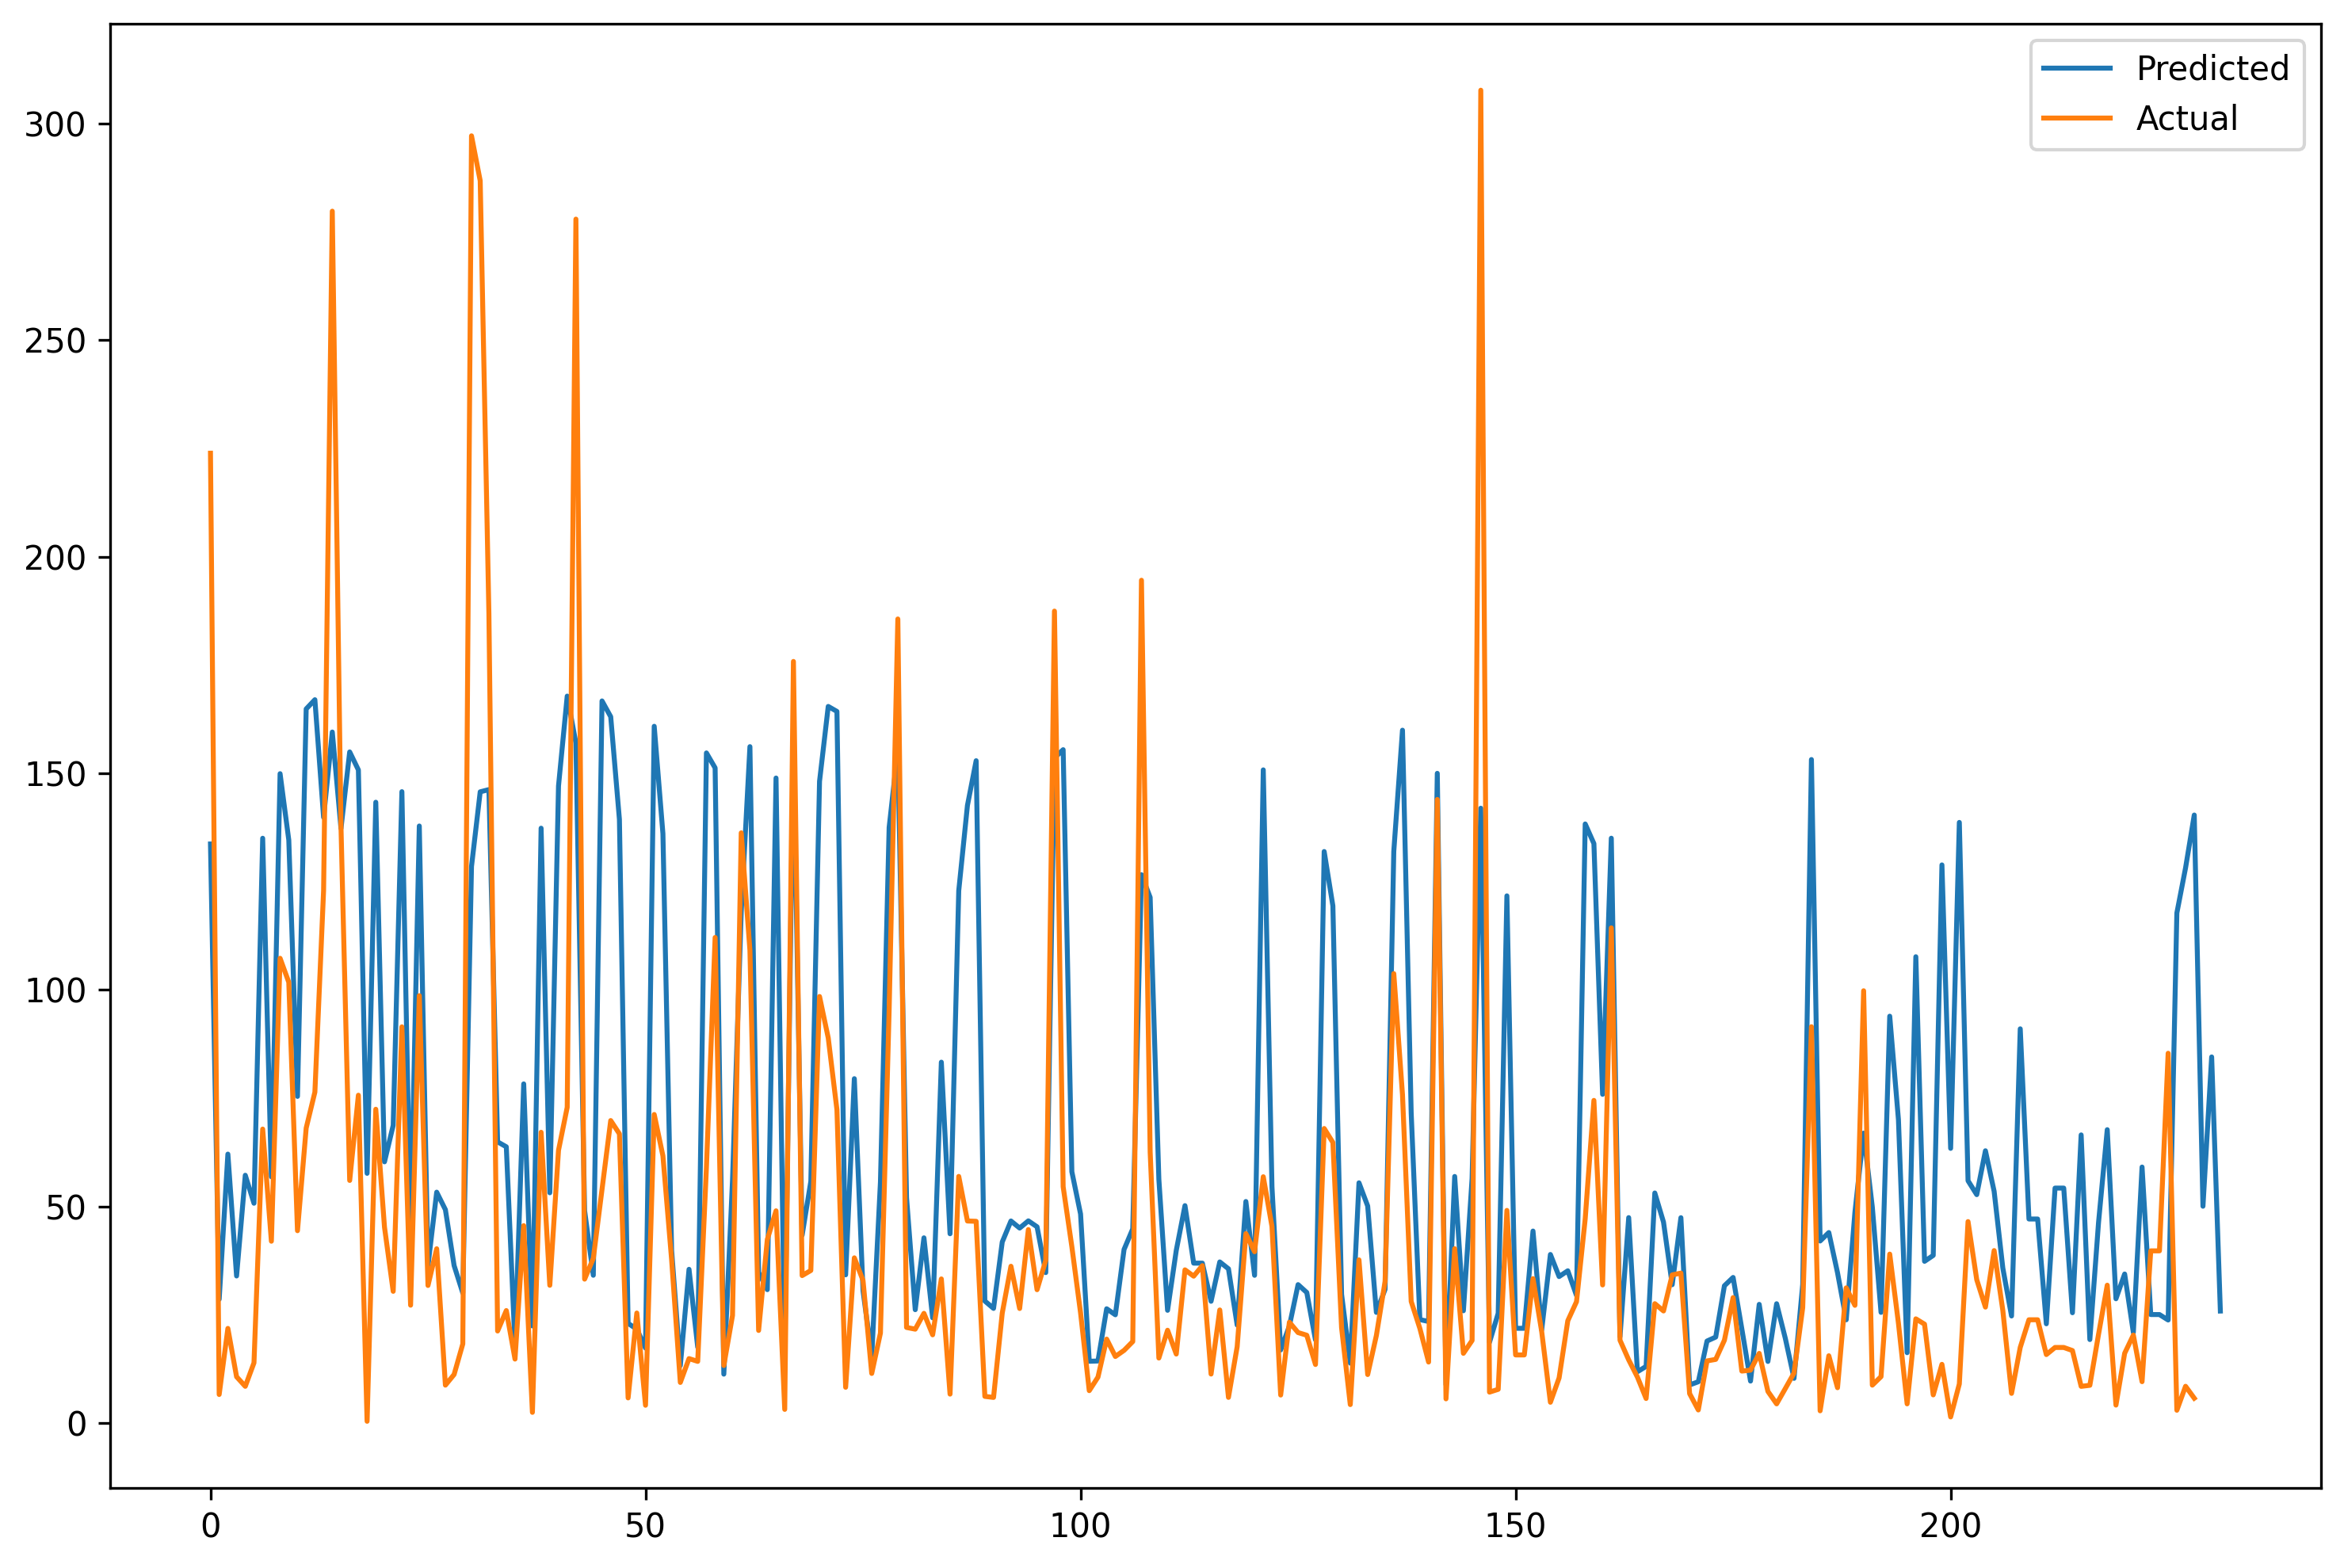

In [155]:
fig, ax = plt.subplots(1,1, figsize=(12,8), dpi=300)
ax.plot(range(X.shape[0]), RF.predict(X), label='Predicted')
ax.plot(range(len(norm_caa)), norm_caa, label='Actual')
ax.legend()
plt.show()

In [156]:
rng = np.random.default_rng(seed=0)
def bootstrapp(y_true,y_pred,n_boots):
    rows = len(y_true)
    error = (y_true.to_numpy().ravel() - y_pred)
    S_CI = np.zeros((n_boots,))
    for i in range(n_boots):
        indx = rng.choice(rows, size=rows, replace=True)
        S_CI[i] = np.mean(np.square(error[indx]))
    return S_CI

In [157]:
def pvit(data: pd.DataFrame,y_true: pd.Series, f: callable):
    rows, columns = data.shape
    Vy = np.var(y_true.to_numpy(), axis=0)
    ST = dict()
    CI = dict()
    for col in data.columns:
        d = data.copy()
        perm_feat = rng.permuted(data[col].to_numpy())
        d[col] = perm_feat
        y_pred = f(d)
        ST[col] = np.square(y_true.to_numpy().ravel()-y_pred.ravel()).mean()/(2*Vy)
        S_CI = bootstrapp(y_true, y_pred,1000)/(2*Vy)
        p0,p1 = np.quantile(S_CI, [0.05,1-0.05])
        CI[col] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), columns=['5th','95th', 'Quantile Width'], index = CI.keys())
    ST = pd.DataFrame(ST.values(), index=ST.keys(), columns=['ST'])
    print(ST)
    FULL = ST.join(CI)
    return FULL

In [158]:
pvit(X_train, y_train, RF.predict)

                       ST
federal_funding  0.073494
state_funding    0.072194
local_funding    0.062889
type_of_work     0.204654
month            0.171282
day              0.162816
year             0.202920
latitude         0.203606
longitude        0.261363


,ST,5th,95th,Quantile Width
federal_funding,0.073494,0.062307,0.084875,0.022568
state_funding,0.072194,0.057170,0.090016,0.032847
local_funding,0.062889,0.053798,0.072389,0.018591
type_of_work,0.204654,0.160001,0.246716,0.086715
month,0.171282,0.145302,0.200834,0.055533
day,0.162816,0.135856,0.192783,0.056927
year,0.202920,0.166243,0.244646,0.078402
latitude,0.203606,0.174309,0.234720,0.060411
longitude,0.261363,0.219481,0.301275,0.081794


In [164]:
pvit(X_train, y_train, RF.predict)

                       ST
federal_funding  0.072495
state_funding    0.072556
local_funding    0.063040
type_of_work     0.211675
month            0.163776
day              0.147903
year             0.184490
latitude         0.216691
longitude        0.274353


,ST,5th,95th,Quantile Width
federal_funding,0.072495,0.061748,0.083938,0.022190
state_funding,0.072556,0.057008,0.089305,0.032297
local_funding,0.063040,0.054447,0.071941,0.017494
type_of_work,0.211675,0.167289,0.258051,0.090762
month,0.163776,0.138574,0.188030,0.049455
day,0.147903,0.123540,0.174228,0.050688
year,0.184490,0.146064,0.222625,0.076561
latitude,0.216691,0.183160,0.252752,0.069591
longitude,0.274353,0.232364,0.317739,0.085374


In [162]:
def pvi(data: pd.DataFrame,y_true: pd.Series, f: callable):
    rows, columns = data.shape
    Vy = np.var(y_true, axis=0)
    SI = dict()
    rolled_data = pd.DataFrame(np.roll(data.to_numpy(),1, axis=0), columns=data.columns)
    for col in data.columns:
        r = rolled_data.copy()
        r[col] = data[col]
        y_pred = f(r)
        SI[col] = 1 - np.square(y_true.to_numpy() - y_pred).mean()/(2*Vy)
    return SI

In [163]:
pvi(X_train, y_train, RF.predict)

{'federal_funding': current_award_amount    0.244906
 dtype: float64,
 'state_funding': current_award_amount    0.233753
 dtype: float64,
 'local_funding': current_award_amount    0.234692
 dtype: float64,
 'type_of_work': current_award_amount    0.264812
 dtype: float64,
 'month': current_award_amount    0.237618
 dtype: float64,
 'day': current_award_amount    0.268029
 dtype: float64,
 'year': current_award_amount    0.233176
 dtype: float64,
 'latitude': current_award_amount    0.318998
 dtype: float64,
 'longitude': current_award_amount    0.328236
 dtype: float64}

In [160]:
def pvi2(data: pd.DataFrame,y_true: pd.Series, f: callable, SI: dict):
    rows, columns = data.shape
    Vy = np.var(y_true)
    SIK = dict()
    rolled_data = pd.DataFrame(np.roll(data.to_numpy(),1, axis=0), columns=data.columns)
    for col1, col2 in it.combinations(data.columns,r=2):
        r = rolled_data.copy()
        r[[col1, col2]] = data[[col1, col2]]
        y_pred = f(r)
        SIK[(col1,col2)] = 1 - np.square(y_true.to_numpy() - y_pred).mean()/(2*Vy) - SI[col1] - SI[col2]
    return SIK

In [33]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [34]:
pd.set_option('display.max_rows', 300)
loc_data = time_features(location_data)
design_of_expmt = loc_data.groupby(by=['region']).agg({'contract_award_amount':['mean','std'],'current_award_amount':[percentile(0.75), 'max']})

In [35]:
design_of_expmt

contract_award_amount                \
                                                   mean           std   
region                                                                  
01 CAPITAL DISTRICT                        6.456343e+06  6.434021e+06   
02 MOHAWK VALLEY                           3.508626e+06  3.257692e+06   
03 CENTRAL NEW YORK                        4.871855e+06  5.579256e+06   
04 GENESEE VALLEY                          2.999064e+06  2.645262e+06   
05 WESTERN NEW YORK                        2.357014e+06  1.906999e+06   
06 SOUTHERN TIER/CENTRAL NEW YORK          2.106953e+06  1.656043e+06   
07 NORTH COUNTRY                           1.216049e+06  5.783098e+05   
08 HUDSON VALLEY                           3.059596e+06  2.769427e+06   
09 SOUTHERN TIER                           2.773528e+06  2.449280e+06   
10 LONG ISLAND                             7.993993e+06  6.344034e+06   
11 NEW YORK CITY                           2.894821e+07  4.806008e+07   

                                  current_award_amount                
                                         percentile_75           max  
region                                                                
01 CAPITAL DISTRICT                       7.507609e+06  2.971630e+07  
02 MOHAWK VALLEY                          4.109431e+06  1.868201e+07  
03 CENTRAL NEW YORK                       5.891915e+06  1.945590e+07  
04 GENESEE VALLEY                         3.625838e+06  1.072882e+07  
05 WESTERN NEW YORK                       2.993791e+06  8.536000e+06  
06 SOUTHERN TIER/CENTRAL NEW YORK         2.679564e+06  6.167580e+06  
07 NORTH COUNTRY                          1.405395e+06  2.136505e+06  
08 HUDSON VALLEY                          3.959390e+06  1.376475e+07  
09 SOUTHERN TIER                          2.991240e+06  1.091397e+07  
10 LONG ISLAND                            8.768973e+06  2.867904e+07  
11 NEW YORK CITY                          2.793070e+07  2.059000e+08

In [36]:
design_of_expmt = pd.DataFrame(design_of_expmt.to_numpy(), index=design_of_expmt.index, columns=['mean','std','75th Percentile','Max'])

In [37]:
design_of_expmt

,mean,std,75th Percentile,Max
region,,,,
01 CAPITAL DISTRICT,6.456343e+06,6.434021e+06,7.507609e+06,2.971630e+07
02 MOHAWK VALLEY,3.508626e+06,3.257692e+06,4.109431e+06,1.868201e+07
03 CENTRAL NEW YORK,4.871855e+06,5.579256e+06,5.891915e+06,1.945590e+07
04 GENESEE VALLEY,2.999064e+06,2.645262e+06,3.625838e+06,1.072882e+07
05 WESTERN NEW YORK,2.357014e+06,1.906999e+06,2.993791e+06,8.536000e+06
06 SOUTHERN TIER/CENTRAL NEW YORK,2.106953e+06,1.656043e+06,2.679564e+06,6.167580e+06
07 NORTH COUNTRY,1.216049e+06,5.783098e+05,1.405395e+06,2.136505e+06
08 HUDSON VALLEY,3.059596e+06,2.769427e+06,3.959390e+06,1.376475e+07
09 SOUTHERN TIER,2.773528e+06,2.449280e+06,2.991240e+06,1.091397e+07


In [38]:
import scipy.stats as ss 
def MC(data: pd.DataFrame):
    index = data.index
    rang_feat = {col: data.loc[col, ['mean','std', 'Max']] for col in index}
    sommand = 0
    for indx in index:
        mini,std, maxi  = rang_feat[indx]
        probs = np.random.normal(loc=mini, scale=np.abs(maxi-mini), size=1_000_000)
        sommand += probs
    return sommand
total_cost = MC(design_of_expmt)

The 95% CDF value for a normal distribution with mean=66,199,093.750737704 and std_dev=181,737,207.64116788 is: 365,130,198.8913455


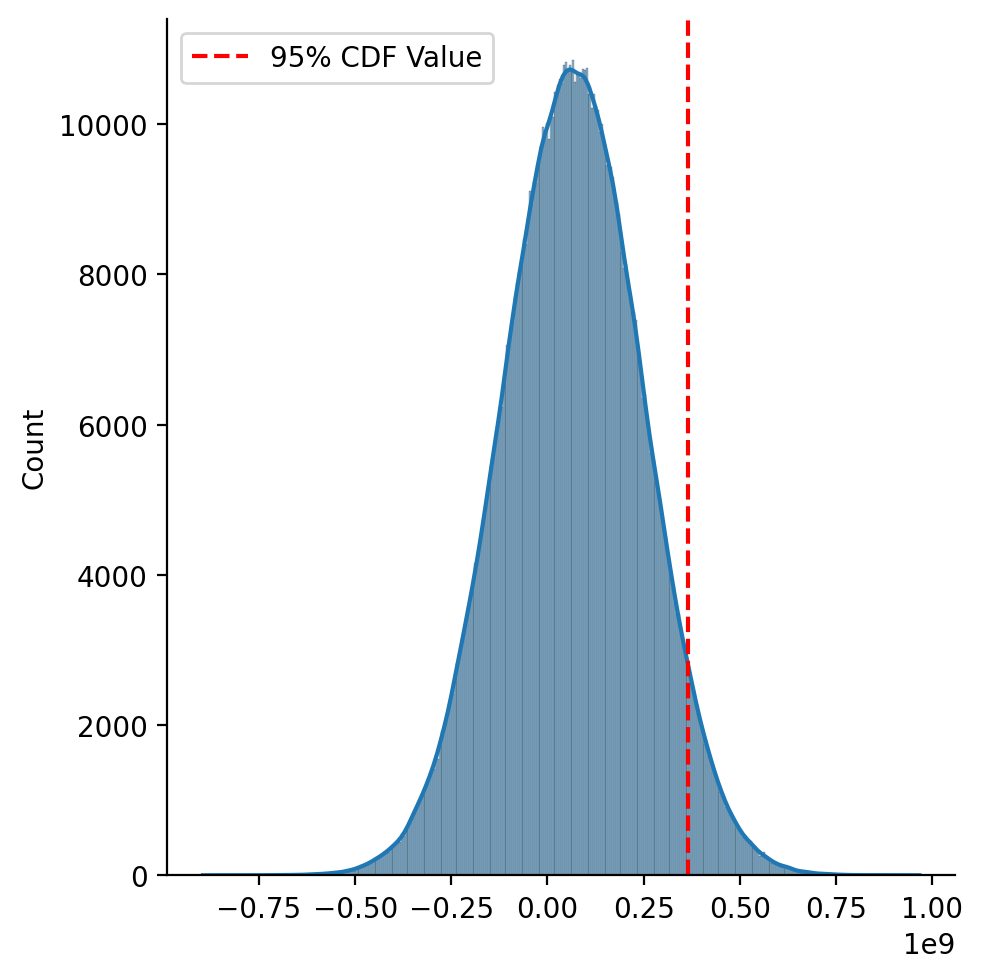

In [40]:
# plt.figure(figsize=(8,12),dpi=500)
sns.displot(total_cost.flatten(), kde=True).fig.set_dpi(200)
cdf_values = ss.norm.ppf(loc = total_cost.mean(), scale=total_cost.std(), q=0.95)
print(f"The 95% CDF value for a normal distribution with mean={total_cost.mean():,} and std_dev={total_cost.std():,} is: {cdf_values:,}")
plt.axvline(x=cdf_values, color='red', linestyle='--', label='95% CDF Value')
plt.legend()
plt.show()

In [41]:
cdf_values = ss.norm.ppf(loc = total_cost.mean(), scale=total_cost.std(), q=0.95)
print(f"The 95% CDF value for a normal distribution with mean={total_cost.mean():,} and std_dev={total_cost.std():,} is: {cdf_values:,}")

The 95% CDF value for a normal distribution with mean=66,199,093.750737704 and std_dev=181,737,207.64116788 is: 365,130,198.8913455


In [232]:
design_of_expmt[['mean','Max']].to_numpy().sum(axis=0)

array([6.62912306e+07, 3.54680879e+08])

In [170]:
# from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
# X_DCN = dropped_contract_numbers.loc[:,new_x_columns]
# Y = dropped_contract_numbers.loc[:,y_column]
# nun = len(X_DCN.type_of_work.unique())
# discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
# Y_binned = discret.fit_transform(Y.to_numpy().reshape((-1,1))).ravel()

# smote = SMOTEN(sampling_strategy='minority',random_state=0)
# X, Y = smote.fit_resample(X_DCN, Y_binned)